# Grid Optimization Analysis

In [41]:
# Set to True to generate the plots.
# (False by default because plots can take a while to generate)
PLOT_SCANS_IN_NOTEBOOK = False

**Contents:**

- Imports, Utilities
- Loading and Saving Grid Optimization Data
- Cleaning Data
    - Improper Angle Tolerance
    - Corner Detection
- Clustering
    - Clustering Comparison
- Testing

In [2]:
import json
import math
import os
from collections import defaultdict
from glob import glob

import matplotlib.cm
import numpy as np
import qcportal as ptl
import qcelemental
from IPython.display import display, HTML
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.figure import Figure
from matplotlib.offsetbox import AnnotationBbox, DrawingArea, TextArea
from openeye import oechem, oedepict
from sklearn import decomposition # PCA
from sklearn.cluster import AgglomerativeClustering
from tqdm.notebook import tqdm, trange

# Local
from util import calc_improper_01

In [3]:
# Number of frames in a 1D scan
SCAN_FRAMES = 27
# Improper angle corresponding to each frame in the 1D scan
IMPROPER_ANGLE_FOR_FRAME = 4 * (np.arange(0, SCAN_FRAMES, 1) - SCAN_FRAMES // 2)
# Difference in improper angle between frames
DEG_BTWN_FRAMES = 4

# The energies are initially in Hartree
KCAL_MOL_PER_HARTREE = 627.509

# Temporary storage when generating 2D images of molecules
TMP_IMG_PATH = "/tmp/tmp.png"
# Resolution when generating 2D images of molecules
IMG_SIZE = 400

In [4]:
class GridOptData:
    """Stores data about each grid optimization and its associated molecule.
    
    Attributes:
        index: str; index of the calculation in the dataset.
        molecule: qcelemental Molecule; the initial molecule for the calculation
        smiles: str; SMILES representation of the molecule for this calculation
        grid_opt_record: GridOptimizationRecord; the main record of the
                         calculation
        scan_energies: (SCAN_FRAMES,) ndarray; energies from the 1D scan -- the
                       indices correspond to setting the improper angle around
                       the trivalent nitrogen in the molecule to -52,-48,...,52
                       degrees
        fitted_molecules: list consisting of the fitted molecule associated with
                          each frame of the 1D scan
        optimization_results: list consisting of optimization results associated
                              with each frame of the 1D scan
        cluster_id: mapping from clustering name (str) to cluster id (int) --
                    for instance, {"wiberg": 5, "distance": 2} means the cluster
                    id is 5 when clustering by "wiberg" and 2 when clusterng by
                    "distance"
        ok_to_use: bool; whether the molecule can be used
        reason_not_ok: str; reason why the molecule cannot be used (if
                       applicable)
        wiberg_bond_orders: Array of adjacency matrices telling the Wiberg Bond
                            Order between atoms in the molecule at each
                            optimization frame. This data member is NOT SAVED,
                            as it can be calculated from the other data.
                            This variable is simply used to cache the results of
                            earlier calls to get_wiberg_bond_orders.
    """

    def __init__(self, index: str):
        """Initializes the GridOptData with the given index.
        
        Args:
            index: index of the calculation in the dataset
        """
        self.index = index
        self.molecule = None
        self.smiles = None
        self.grid_opt_record = None
        self.scan_energies = None
        self.fitted_molecules = None
        self.optimization_results = None
        self.cluster_id = {}
        self.ok_to_use = True
        self.reason_not_ok = None
        
        self.wiberg_bond_orders = None

    #
    # Special setters
    #

    def set_not_ok(self, reason: str):
        """Marks this molecule as not okay.
        
        Args:
            reason: The reason why the molecule is being marked as not okay.
        """
        self.ok_to_use = False
        self.reason_not_ok = reason

    #
    # Special getters
    #

    def get_restraint_indices(self) -> [int]:
        """Returns indices of atoms, in the molecule, that were restrained
        during the grid optimization.
        
        Returns:
            A list of four indices, with the first corresponding to the
            trivalent nitrogen.
        """
        assert self.grid_opt_record is not None, \
            "`grid_opt_record` is not initialized"
        return self.grid_opt_record.keywords.scans[0].__dict__['indices']

    def get_wiberg_bond_orders(self) -> [np.ndarray]:
        """Gets Wiberg Bond Order adjacency matrix for each optimization frame.
        
        Returns:
            List of SCAN_FRAMES adjacency matrices, where each matrix uses entry
            i,j to store bond order between atom i and atom j.
        """
        assert self.optimization_results is not None, \
            "`optimization_results` is not initialized"
        
        if self.wiberg_bond_orders is not None:
            return self.wiberg_bond_orders

        self.wiberg_bond_orders = []
        for result in self.optimization_results:
            # Reshape the initial 1D array into a 2D adjacency matrix.
            wbo = np.array(result.extras["qcvars"]["WIBERG_LOWDIN_INDICES"])
            n = int(len(wbo)**0.5)
            wbo = wbo.reshape(n, n)
            self.wiberg_bond_orders.append(wbo)
        return self.wiberg_bond_orders
    
    def get_wiberg_bond_orders_around_nitrogen(self) -> np.ndarray:
        """Gets Wiberg Bond orders around the trivalent nitrogen.
        
        Returns:
            (SCAN_FRAMES,3) array with the Wiberg Bond Orders
        """
        nitrogen, *nbors = self.get_restraint_indices()
        all_wbos = self.get_wiberg_bond_orders()
        nitrogen_wbos = np.zeros((SCAN_FRAMES, 3))
        for i in range(len(all_wbos)):
            for j in range(len(nbors)):
                nitrogen_wbos[i, j] = all_wbos[i][nitrogen, nbors[j]]
        return nitrogen_wbos

    #
    # Plotting functions
    #

    def plot_1d_scan(self, ax: plt.Axes, show_title=True, info=None):
        """Plots the energies onto the given axis.
        
        Args:
            ax: Matplotlib Axes for displaying the molecule image.
            show_title: whether to display the title
            info: Additional info to place in the title - the title then appears
                  as "{info} | {molecular formula}"
        Side effects:
            - Changes the content of the Axes
        """
        ax.plot(IMPROPER_ANGLE_FOR_FRAME, self.scan_energies)
        if show_title:
            ax.set_title((f"{info} | " if info is not None else "") +
                         f"{self.molecule.get_molecular_formula()}")
        # Ticks at every other improper angle
        ax.set_xticks(IMPROPER_ANGLE_FOR_FRAME[1::4])
        ax.set_ylabel("energy (kcal/mol)")

    def plot_wbo(self, ax: plt.Axes, show_title=True, info=None):
        """Plots the Wiberg bond order around the trivalent nitrogen at
        each frame onto the given axis.
        
        Args:
            ax: Matplotlib Axes for displaying the molecule image.
            show_title: whether to display the title
            info: Additional info to place in the title - the title then appears
                  as "{info} | {molecular formula}"
        Side effects:
            - Changes the content of the Axes
        """
        nitrogen, *nbors = self.get_restraint_indices()
        nitrogen_wbos = self.get_wiberg_bond_orders_around_nitrogen()

        for i in range(len(nbors)):
            ax.plot(IMPROPER_ANGLE_FOR_FRAME,
                    nitrogen_wbos[:, i],
                    label=f"nbor {i} ({oechem.OEGetAtomicSymbol(int(self.molecule.atomic_numbers[nbors[i]]))})")
        ax.plot(IMPROPER_ANGLE_FOR_FRAME,
                np.sum(nitrogen_wbos, axis=1),
                label="Total")
        ax.legend()

        if show_title:
            ax.set_title((f"{info} | " if info is not None else "") +
                         f"{self.molecule.get_molecular_formula()}")
        # Ticks at every other improper angle
        ax.set_xticks(IMPROPER_ANGLE_FOR_FRAME[1::4])
        ax.set_ylabel("WBO")

    def display_molecule_img(self, ax: plt.Axes):
        """Renders a 2D depiction of this molecule onto the given Axis object.
        
        The depiction is rendered by first saving a temporary image at
        TMP_IMG_PATH with the Openeye toolkit, then loading the image and
        feeding it into matplotlib.

        Args:
            ax: Matplotlib Axis for displaying the molecule image.
        Side effects:
            - Generates and removes an image at TMP_IMG_PATH
            - Changes the content of the Axis
        """
        mol = oechem.OEMol()
        oechem.OESmilesToMol(mol, self.smiles)
        oedepict.OEPrepareDepiction(mol)
        opts = oedepict.OE2DMolDisplayOptions(IMG_SIZE, IMG_SIZE,
                                              oedepict.OEScale_AutoScale)
        opts.SetTitleLocation(oedepict.OETitleLocation_Hidden)
        opts.SetBackgroundColor(oechem.OEWhite.SetA(100))
        disp = oedepict.OE2DMolDisplay(mol, opts)
        ofs = oechem.oeofstream(TMP_IMG_PATH)
        ext = oechem.OEGetFileExtension(TMP_IMG_PATH)
        oedepict.OERenderMolecule(ofs, ext, disp)
        ofs.close()

        # Read the image into matplotlib and display.
        img = plt.imread(TMP_IMG_PATH)
        os.remove(TMP_IMG_PATH)
        ax.imshow(img)
        ax.set_axis_off()

    #
    # Saving and loading locally
    #

    def save_to_directory(self, dirname=None):
        """Saves the data associated with this object to several files in a directory.
        
        Args:
            dirname: Name of the directory to save to -- if not provided, defaults
                     to `./{self.index}`
        """
        if dirname is None: dirname = self.index

        if not os.path.exists(dirname):
            os.mkdir(dirname)

        metadata = {
            "index":
                self.index,
            "smiles":
                self.smiles,
            "scan_energies":
                None
                if self.scan_energies is None else list(self.scan_energies),
            "ok_to_use":
                self.ok_to_use,
            "reason_not_ok":
                self.reason_not_ok,
            "cluster_id":
                self.cluster_id,
            "num_fitted_molecules":
                None if self.fitted_molecules is None else len(
                    self.fitted_molecules),
            "num_optimization_results":
                None if self.optimization_results is None else len(
                    self.optimization_results)
        }
        with open(f"{dirname}/metadata.json", "w") as f:
            json.dump(metadata, f)

        if self.molecule is not None:
            self.molecule.to_file(f"{dirname}/molecule.json")

        if self.grid_opt_record is not None:
            with open(f"{dirname}/grid_opt_record.json", "w") as f:
                f.write(self.grid_opt_record.json())

        if self.fitted_molecules is not None:
            for i in range(len(self.fitted_molecules)):
                self.fitted_molecules[i].to_file(
                    f"{dirname}/fitted_molecule_{i}.json")

        if self.optimization_results is not None:
            for i in range(len(self.optimization_results)):
                with open(f"{dirname}/optimization_results_{i}.json", "w") as f:
                    f.write(self.optimization_results[i].json())

    def load_from_directory(self, dirname):
        """Loads data for this object from several files in a directory.
        
        Existing data for this object is overwritten.
        
        Args:
            dirname: Name of the directory to load from.
        """
        with open(f"{dirname}/metadata.json", "r") as f:
            metadata = json.load(f)

        self.index = metadata["index"]
        self.smiles = metadata["smiles"]
        self.scan_energies = None if metadata[
            "scan_energies"] is None else np.array(metadata["scan_energies"])
        self.ok_to_use = metadata["ok_to_use"]
        self.reason_not_ok = metadata["reason_not_ok"]
        self.cluster_id = metadata["cluster_id"]

        self.molecule = qcelemental.models.Molecule.from_file(
            f"{dirname}/molecule.json") if os.path.exists(
                f"{dirname}/molecule.json") else None
        self.grid_opt_record = ptl.models.GridOptimizationRecord.parse_file(
            f"{dirname}/grid_opt_record.json") if os.path.exists(
                f"{dirname}/grid_opt_record.json") else None
        self.fitted_molecules = None if metadata[
            "num_fitted_molecules"] is None else [
                qcelemental.models.Molecule.from_file(
                    f"{dirname}/fitted_molecule_{i}.json")
                for i in range(metadata["num_fitted_molecules"])
            ]
        self.optimization_results = None if metadata[
            "num_optimization_results"] is None else [
                ptl.models.records.ResultRecord.parse_file(
                    f"{dirname}/optimization_results_{i}.json")
                for i in range(metadata["num_optimization_results"])
            ]


In [5]:
# Width of the overall figure when plotting multiple molecules.
PLOT_FIG_WIDTH = 13
# Height of each row when plotting multiple molecules.
PLOT_ROW_HEIGHT = 3

# PDF settings, in inches.
PDF_PAGE_WIDTH = 8.5
PDF_PAGE_HEIGHT = 2


def plot_scans_and_mols(data: [GridOptData], display_idx_in_title=False):
    """Plots each data's 1D scan, WBO, and molecule image.
    
    Avoids molcules that are not `ok_to_use`.
    
    Args:
        data: grid optimization data
        display_idx_in_title: if True, includes the index of the object in
                              `data` in the title of each plot
    """
    if not PLOT_SCANS_IN_NOTEBOOK: return
    
    rows = sum(1 for d in data if d.ok_to_use)
    fig, ax = plt.subplots(
        rows,
        3,  # cols - 1D scan, WBO, img
        figsize=(PLOT_FIG_WIDTH, PLOT_ROW_HEIGHT * rows))
    fig.tight_layout()  # Improve spacing between plots
    ax = np.atleast_2d(ax)

    # Iterate and create the plots.
    idx = 0
    for r in range(rows):
        # Increment the index until the next good data is found.
        while idx < len(data) and not data[idx].ok_to_use:
            idx += 1

        # Only plot if the index is within bounds.
        if idx < len(data):
            if display_idx_in_title:
                data[idx].plot_1d_scan(ax[r, 0], f"Molecule {idx}")
            else:
                data[idx].plot_1d_scan(ax[r, 0])
            data[idx].plot_wbo(ax[r, 1])
            data[idx].display_molecule_img(ax[r, 2])
            idx += 1  # Remember to bump index.

    plt.show()


def plot_scans_and_mols_in_file(data: [GridOptData],
                                filename="grid_opt_data.pdf",
                                title="Grid Optimization Data Visualization"):
    """Plots each data's 1D scan, WBO, and molecule image in a file.
    
    Data are avoided if they are not `ok_to_use`. Each data is given one page.
    
    Args:
        data: grid optimization data
        filename: PDF file to save to
        title: appears on the first page
    """
    SMALL_SIZE = 8
    plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)  # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=6)  # legend fontsize

    with PdfPages(filename) as pdf:
        # Create title page.
        titlePage = plt.figure(figsize=(PLOT_FIG_WIDTH, PLOT_ROW_HEIGHT))
        titlePage.clf()
        titlePage.text(0.5,
                       0.5,
                       title,
                       transform=titlePage.transFigure,
                       size=24,
                       ha="center")
        pdf.savefig(bbox_inches="tight", pad_inches=0.25)
        plt.close()

        for d in tqdm(data):
            if not d.ok_to_use: continue
            fig, ax = plt.subplots(1,
                                   3,
                                   figsize=(PDF_PAGE_WIDTH, PDF_PAGE_HEIGHT))
            fig.tight_layout()
            
            # Display the 1d scan, WBO, and molecule image.
            d.plot_1d_scan(ax[0], show_title=False)
            ax[0].set_xlabel("Improper Angle (degrees)")
            d.plot_wbo(ax[1], show_title=False)
            ax[1].set_xlabel("Improper Angle (degrees)")
            d.display_molecule_img(ax[2])

            # Put the SMILES at the top of each page.
            plt.text(
                0.03,
                0.98,
                d.smiles if d.smiles else d.molecule.get_molecular_formula(),
                transform=fig.transFigure,
                size=10)
            
            # Output the figure onto a new page of the PDF.
            pdf.savefig(fig, bbox_inches="tight", pad_inches=0.25, dpi=300)
            plt.close()

## Loading and Saving Grid Optimization Data

In [6]:
# IDs of bad optimization records, courtesy of Trevor Gokey
BAD_ENTRY_OPT_RECORDS = {
    "9425214", "9425246", "9425251", "9425254", "9425255", "9425256", "9425268",
    "9425294", "9425300", "9425306", "9425307", "9425316", "9425333", "9425337",
    "9425346", "9425371", "9425386", "9425397", "9425398", "9425399", "9425400",
    "9425405", "9425406", "9425415", "9425427", "9425432", "9425441", "9425450",
    "9425456", "9425459", "9425468", "9425491", "9425493", "9425500", "9425519"
}

def load_grid_opt_data(dirname=None):
    """Retrieves the grid optimization dataset from either the MolSSI server or a local directory.
    
    Args:
        dirname: If `None`, downloads the data directly from the server. Otherwise,
                 `dirname` should be a directory containing multiple child
                 directories, where each chld directory was created by calling
                 `GridOptData.save_to_directory`
    Returns:
        data: List of GridOptData
    """
    print("Loading Grid Optimization Data")
    
    # Loading locally
    if dirname is not None:
        data = []
        for subdir in tqdm(glob(f"{dirname}/*")):
            d = GridOptData("tmpname")
            d.load_from_directory(subdir)
            data.append(d)
        return data
    
    # Loading from server
    client = ptl.FractalClient()
    ds = client.get_collection('GridOptimizationDataset',
                               'OpenFF Trivalent Nitrogen Set 1')

    data = []
    molecule_ids = [
        ds.get_entry(index).initial_molecule for index in ds.df.index
    ]
    molecules = client.query_molecules(molecule_ids)
    grid_opt_record_ids = [
        ds.get_entry(index).object_map['default'] for index in ds.df.index
    ]
    grid_opt_records = client.query_procedures(grid_opt_record_ids)

    for index, mol_id, mol, grid_opt_record_id, grid_opt_record in tqdm(
            tuple(zip(ds.df.index, molecule_ids, molecules, grid_opt_record_ids, grid_opt_records))):
        ds_entry = ds.get_entry(index)
        d = GridOptData(index)
        data.append(d)
        
        # These have already been determined to be bad.
        if grid_opt_record_id in BAD_ENTRY_OPT_RECORDS:
            d.set_not_ok("Pre-marked as bad")

        d.molecule = mol
        d.smiles = ds_entry.attributes['canonical_explicit_hydrogen_smiles']
        d.grid_opt_record = grid_opt_record

        # 1D scan energies
        energies = np.zeros(SCAN_FRAMES)
        energies_dict = grid_opt_record.get_final_energies()
        if len(energies_dict) != SCAN_FRAMES:
            # If there was no optimization data, this molecule is bad.
            d.set_not_ok(f"1D scan only had {len(energies_dict)} frames")
            continue
        for frame, energy in energies_dict.items():
            # Convert energies from Hartree to kcal/mol.
            energies[frame[0]] = energy * KCAL_MOL_PER_HARTREE
        # Normalize the energies by subtracting the minimum energy.
        energies -= np.min(energies)
        d.scan_energies = energies

        # Fitted molecules
        final_molecules = grid_opt_record.get_final_molecules()
        d.fitted_molecules = [
            final_molecules[(i,)] for i in range(SCAN_FRAMES)
        ]
        
        # Optimization results
        final_results = grid_opt_record.get_final_results()
        d.optimization_results = [
            final_results[(i,)] for i in range(SCAN_FRAMES)
        ]

    return data

def save_grid_opt_data(data: [GridOptData], dirname="./grid_opt_data"):
    """Saves all the data by creating one directory per molecule in the given directory.
    
    Args:
        dirname: Directory in which to save all the molecules.
    """
    if not os.path.exists(dirname):
        os.mkdir(dirname)
    print("Saving Grid Optimization Data")
    for i in trange(len(data)):
        data[i].save_to_directory(f"{dirname}/{i}")

In [7]:
GRID_OPT_DATA = load_grid_opt_data(dirname="./grid_opt_data")

Loading Grid Optimization Data


In [8]:
# Not needed unless downloading from server
# save_grid_opt_data(GRID_OPT_DATA, dirname="./grid_opt_data")

## Cleaning Data

Look for irregularities in the data and mark bad molecules.

### Improper Angle Tolerance

Look for grid optimization frames where the improper angle of the trivalent nitrogen differs from the desired amount by more than IMPROPER_TOLERANCE degrees. This is necessary because, even though the improper angle around the trivalent nitrogen is restrained during grid optimization, it may still vary during the calculation.

In [9]:
# Maximum amount, in degrees, that the actual improper angle in a
# molecule can differ from the desired angle.
IMPROPER_TOLERANCE = 1e-5

def find_mismatch_impropers(data: [GridOptData]):
    """
    Finds and marks molecules where the improper angle around the trivalent nitrogen
    diverges from expected.
    
    Args:
        data: grid optimization data
    """
    for d in tqdm(data):
        if not d.ok_to_use: continue
        
        restraint_indices = d.get_restraint_indices()
        assert len(restraint_indices) == 4, \
               f"There are {len(restraint_indices)} restrained atoms in entry {idx}."

        for frame_idx in range(SCAN_FRAMES):
            molecule = d.fitted_molecules[frame_idx]

            actual_angle = calc_improper_01.calc_improper_angle(
                molecule.geometry[restraint_indices[0]],
                molecule.geometry[restraint_indices[1]],
                molecule.geometry[restraint_indices[2]],
                molecule.geometry[restraint_indices[3]],
                True)
            ideal_angle = IMPROPER_ANGLE_FOR_FRAME[frame_idx]
            delta = abs(actual_angle - ideal_angle)

            if delta > IMPROPER_TOLERANCE:
                print(f"Entry {idx} ({molecule.name}), frame {frame_idx} |"
                      f" expected: {ideal_angle}, actual: {actual_angle}")
                d.set_not_ok(f"Impropver angle at frame {frame_idx} diverges too much")

In [10]:
# Prints out and marks molecules that fail the check.
find_mismatch_impropers(GRID_OPT_DATA)

### Corner Detection

Detect 1D scan plots with corners in them. Corners are abnormal and may be indicative of a failure in the grid optimizations.

In [11]:
def find_scans_with_corners(data: [GridOptData],
                            corner_difference_magnitude: float) -> [int]:
    """
    Detecting corners presents a slight challenge because we do not have
    continuous data. Here, we attempt to do it by checking if the left and
    right slopes at each point in the plot have opposite signs and differ by
    at least corner_difference_magnitude.
    
    Strictly speaking, corner_difference_magnitude is in units of
    (kcal/mol) / degree
    
    Args:
        data: grid optimization data
        corner_difference_magnitude: magnitude of slope change for classifying as a corner
    Returns:
        indices_with_corners: indices of items in `data` that have corners
    """
    indices_with_corners = []

    for idx in range(len(data)):
        d = data[idx]
        if not d.ok_to_use: continue
        for i in range(1, SCAN_FRAMES -
                       1):  # only cover frames with both left and right frame
            # Slope is the energy divided by the number of degrees (4)
            left_slope = (d.scan_energies[i] -
                          d.scan_energies[i - 1]) / DEG_BTWN_FRAMES
            right_slope = (d.scan_energies[i + 1] -
                           d.scan_energies[i]) / DEG_BTWN_FRAMES

            are_opposite_direction = \
                (left_slope < 0 and right_slope > 0) or \
                (left_slope > 0 and right_slope < 0)
            have_sufficient_difference = \
                abs(left_slope - right_slope) >= corner_difference_magnitude

            if are_opposite_direction and have_sufficient_difference:
                indices_with_corners.append(idx)
                print(
                    f"1D scan for molecule {idx:3} ({d.molecule.get_molecular_formula()}) has a corner"
                )
                break  # no need to check the rest of the plot

    print(f"{len(indices_with_corners)} scans found with corners")
    return indices_with_corners

In [12]:
CORNER_INDICES = find_scans_with_corners(GRID_OPT_DATA, 0.4000)

1D scan for molecule   0 (C8ClH6N5) has a corner
1D scan for molecule  11 (C3H9N) has a corner
1D scan for molecule  17 (C7Cl2H8NO2P) has a corner
1D scan for molecule  20 (C3H11N2) has a corner
1D scan for molecule  24 (C10H8N2O5S2) has a corner
1D scan for molecule  28 (C21H20NOP) has a corner
1D scan for molecule  50 (C8H8N2O3) has a corner
1D scan for molecule  53 (CH5NO3S) has a corner
1D scan for molecule  63 (C12FH8N3O7S) has a corner
1D scan for molecule  69 (C13H13NO3S) has a corner
1D scan for molecule  77 (C6H6N4OS2) has a corner
1D scan for molecule  82 (C5H11NO4) has a corner
1D scan for molecule  83 (C6Cl3H5NOP) has a corner
1D scan for molecule  84 (C2H8NO2PS) has a corner
1D scan for molecule 103 (C9H9NO5S4) has a corner
1D scan for molecule 120 (C20H21N3O4S) has a corner
1D scan for molecule 124 (C12H15NO4) has a corner
1D scan for molecule 125 (C4H12NOP) has a corner
1D scan for molecule 129 (C6H11N3O3S) has a corner
1D scan for molecule 143 (C10H13NO3) has a corner
1

In [13]:
# Display the plots of the data that were found to have corners
data_with_corners = [GRID_OPT_DATA[i] for i in CORNER_INDICES]
plot_scans_and_mols(data_with_corners)

In [14]:
# Mark the plots with (automatically detected) corners as bad
for idx in CORNER_INDICES:
    GRID_OPT_DATA[idx].set_not_ok("Plot contains corner")

**No more entries should be marked bad after this.**

## Clustering
Clustering the molecules by energy profile.

In [45]:
# Number of clusters
DEFAULT_NUM_CLUSTERS = 15

def make_clusters(data: [GridOptData],
                  distance_function,
                  clustering_name: str,
                  n_clusters=DEFAULT_NUM_CLUSTERS):
    """
    Performs hierarchical agglomerative clustering and assigns cluster ids
    to the given data.
    
    Args:
        data: Grid optimization data
        distance_function: function that takes in two GridOptData and returns a
                           float describing the "distance" between them -- closer
                           objects are more similar
        clustering_name: identifier for this clustering in the `cluster_id` dict in
                         each GridOptData object
        n_clusters: number of clusters for hierarchical agglomerative clustering
    Side effects:
        - the `cluster_id` field in each object receives an additional entry of
          {clustering_name: id} where id is in the range [0, n_clusters)
    """
    good_data = [d for d in data if d.ok_to_use]
    
    distance_matrix = np.zeros((len(good_data), len(good_data)))
    for i in range(len(good_data)):
        for j in range(len(good_data)):
            distance_matrix[i][j] = distance_function(good_data[i],
                                                      good_data[j])
    cluster_ids = AgglomerativeClustering(
        n_clusters=n_clusters, affinity="precomputed",
        linkage="average").fit_predict(distance_matrix)
    for i in range(len(good_data)):
        good_data[i].cluster_id[clustering_name] = cluster_ids[i]


def make_cluster_mapping(data: [GridOptData], clustering_name: str) -> {
        int: [GridOptData]
}:
    """Groups together data in the same cluster.
    
    Args:
        data: Grid optimization data.
        clustering_name: identifier for this clustering in the `cluster_id` dict in
                         each GridOptData object
    Returns:
        cluster_mapping: Mapping from cluster id to data in the cluster.
    """
    cluster_mapping = defaultdict(list)
    for d in data:
        if d.ok_to_use: cluster_mapping[d.cluster_id[clustering_name]].append(d)
    return cluster_mapping


def clustering_jaccard_index(data: [GridOptData], cname1: str,
                             cname2: str) -> float:
    """Calculates the Jaccard Index of the two clusterings.
    
    To do this, it constructs a contingency table by looking at each pair of
    items in the data. It then looks at whether cname1 assigned this pair to
    the same cluster, and whether cname2 assigned this pair to the same cluster.
    Based on what cname1 and cname2 did, the appropriate cell in the contingency
    table is populated.
    
    For more information, refer to the jaccard function from the R clusteval
    package:
    https://rdrr.io/github/ramhiser/clusteval/man/jaccard.html
    
    Args:
        data: Grid optimization data.
        cname1: identifier for the first clustering
        cname2: identifier for the second clustering
    Returns:
        Jaccard Index of the two clusterings.
    """
    table = np.zeros((2, 2), dtype=int)
    data = [d for d in data if d.ok_to_use]
    for i in range(len(data)):
        for j in range(i + 1, len(data)):
            a, b = data[i], data[j]
            decision1 = a.cluster_id[cname1] == b.cluster_id[cname1]
            decision2 = a.cluster_id[cname2] == b.cluster_id[cname2]
            table[int(decision1), int(decision2)] += 1

    union = table[0, 1] + table[1, 0] + table[1, 1]
    return 0 if union == 0 else table[1, 1] / union


def show_clusters(data: [GridOptData], clustering_name: str):
    """Displays the plots associated with each cluster.
    
    Args:
        data: Grid optimization data. `cluster_id` is assumd to be set for
              all molecules that are `ok_to_use`
        clustering_name: identifier for this clustering in the `cluster_id` dict in
                         each GridOptData object
    """
    if not PLOT_SCANS_IN_NOTEBOOK: return
    cluster_mapping = make_cluster_mapping(data, clustering_name)
    for c in sorted(cluster_mapping):
        display(
            HTML(f"<h1>Cluster {c} ({len(cluster_mapping[c])} molecules)</h1>"))
        plot_scans_and_mols(cluster_mapping[c])


def save_smiles_from_clusters(data, clustering_name, filename=None):
    """Saves SMILES strings of molecules in each cluster into a JSON file.
    
    Args:
        data: Grid optimization data.
        clustering_name: identifier for this clustering in the `cluster_id` dict in
                         each GridOptData object
        filename: Name of the file to save the data to. Defaults to
                  "{clustering_name}_clusters.json"
    """
    cluster_mapping = make_cluster_mapping(data, clustering_name)
    smiles_in_clusters = {
        int(c): [d.smiles for d in cluster_mapping[c]] for c in cluster_mapping
    }
    if filename is None:
        filename = f"{clustering_name}_clusters.json"
    with open(filename, "w") as f:
        json.dump(smiles_in_clusters, f)

In [16]:
def scan_energy_distance(a: GridOptData, b: GridOptData) -> float:
    """Returns distance between 1D scan energies in two pieces of data.
    
    Args:
        a: Object 1
        b: Object 2
    Returns:
        Euclidean distance between a.scan_energies and b.scan_energies
    """
    return np.linalg.norm(a.scan_energies - b.scan_energies)

make_clusters(GRID_OPT_DATA, scan_energy_distance, "scan_energy")
show_clusters(GRID_OPT_DATA, "scan_energy")

In [17]:
def normalized_scan_energy_distance(a: GridOptData, b: GridOptData) -> float:
    """Returns distance between 1D scan energies in two pieces of data, after
    normalizing each scan's energies to the range [0, 1].
    
    Args:
        a: Object 1
        b: Object 2
    Returns:
        Euclidean distance between a.scan_energies and b.scan_energies, after
        dividing each `scan_energies` by its max. If the max is 0,
        `scan_energies` just becomes 0.
    """
    a_max = np.max(a.scan_energies)
    a_normalized = 0 if a_max == 0 else a.scan_energies / a_max
    b_max = np.max(b.scan_energies)
    b_normalized = 0 if b_max == 0 else b.scan_energies / b_max
    return np.linalg.norm(a_normalized - b_normalized)


make_clusters(GRID_OPT_DATA,
              normalized_scan_energy_distance,
              "norm_scan_energy")

In [18]:
def wiberg_distance(a: GridOptData, b: GridOptData, wbo_type: str) -> float:
    """Returns squared difference between total, max, or min Wiberg bond orders
    around the trivalent nitrogen in two pieces of data.
    
    Args:
        a: Object 1
        b: Object 2
        wbo_type: Either "total", "max", or "min" to indicate summing up the WBO
                  around the trivalent nitrogen, taking the max, or taking the
                  min.
    Returns:
        Squared difference between average total or max or min Wiberg Bond Order
        around the trivalent nitrogen in a and b.
    """
    wib_a = a.get_wiberg_bond_orders_around_nitrogen()
    wib_b = b.get_wiberg_bond_orders_around_nitrogen()
    if wbo_type == "total":
        wib_a = wib_a.sum(axis=1)
        wib_b = wib_b.sum(axis=1)
    elif wbo_type == "max":
        wib_a = wib_a.max(axis=1)
        wib_b = wib_b.max(axis=1)
    elif wbo_type == "min":
        wib_a = wib_a.min(axis=1)
        wib_b = wib_b.min(axis=1)
    else:
        raise RuntimeError(f"Invalid wbo_type: {wbo_type}")
    wib_a = wib_a.mean()
    wib_b = wib_b.mean()
    return np.power(wib_a - wib_b, 2.0)

total_wiberg_distance = lambda a, b: wiberg_distance(a, b, "total")
max_wiberg_distance = lambda a, b: wiberg_distance(a, b, "max")
min_wiberg_distance = lambda a, b: wiberg_distance(a, b, "min")

make_clusters(GRID_OPT_DATA, total_wiberg_distance, "total_wiberg")
show_clusters(GRID_OPT_DATA, "total_wiberg")

In [19]:
def all_wiberg_distance(a: GridOptData, b: GridOptData, wbo_type: str) -> float:
    """Considers total, max, or min Wiberg bond orders at all frames.
    
    Args:
        a: Object 1
        b: Object 2
        wbo_type: Either "total", "max", or "min" to indicate summing up the WBO
                  around the trivalent nitrogen, taking the max, or taking the
                  min.
    Returns:
        Euclidean distance between vectors of total, max, or min Wiberg bond
        orders at each optimization frame.
    """
    wib_a = a.get_wiberg_bond_orders_around_nitrogen()
    wib_b = b.get_wiberg_bond_orders_around_nitrogen()
    if wbo_type == "total":
        wib_a = wib_a.sum(axis=1)
        wib_b = wib_b.sum(axis=1)
    elif wbo_type == "max":
        wib_a = wib_a.max(axis=1)
        wib_b = wib_b.max(axis=1)
    elif wbo_type == "min":
        wib_a = wib_a.min(axis=1)
        wib_b = wib_b.min(axis=1)
    else:
        raise RuntimeError(f"Invalid wbo_type: {wbo_type}")
    return np.linalg.norm(wib_a - wib_b)

total_all_wiberg_distance = lambda a, b: all_wiberg_distance(a, b, "total")
max_all_wiberg_distance = lambda a, b: all_wiberg_distance(a, b, "max")
min_all_wiberg_distance = lambda a, b: all_wiberg_distance(a, b, "min")

In [20]:
def avg_wiberg_at_minima_distance(a: GridOptData, b: GridOptData,
                                  wbo_type: str) -> float:
    """Considers total, max, or min Wiberg bond orders only at local minima in
    the 1D scan.
    
    Args:
        a: Object 1
        b: Object 2
        wbo_type: Either "total", "max", or "min" to indicate summing up the WBO
                  around the trivalent nitrogen, taking the max, or taking the
                  min.
    Returns:
        Squared difference between average total, max, or min Wiberg bond order
        at the local minima in the 1D scan.
    """

    def find_local_minima_indices(d: GridOptData):
        """Generates indices of local minima in the 1D scan."""
        minima = []
        for i in range(1, SCAN_FRAMES - 1):
            if d.scan_energies[i] < d.scan_energies[
                    i - 1] and d.scan_energies[i] < d.scan_energies[i + 1]:
                minima.append(i)
        if len(minima) == 0:
            # No local minima -- just take the absolute min
            return [np.argmin(d.scan_energies)]
        return minima

    wib_a = a.get_wiberg_bond_orders_around_nitrogen()
    wib_b = b.get_wiberg_bond_orders_around_nitrogen()
    if wbo_type == "total":
        wib_a = wib_a.sum(axis=1)
        wib_b = wib_b.sum(axis=1)
    elif wbo_type == "max":
        wib_a = wib_a.max(axis=1)
        wib_b = wib_b.max(axis=1)
    elif wbo_type == "min":
        wib_a = wib_a.min(axis=1)
        wib_b = wib_b.min(axis=1)
    else:
        raise RuntimeError(f"Invalid wbo_type: {wbo_type}")
    wib_a = wib_a[find_local_minima_indices(a)].mean()
    wib_b = wib_b[find_local_minima_indices(b)].mean()
    return np.power(wib_a - wib_b, 2.0)


total_avg_at_min_wiberg_distance = lambda a, b: avg_wiberg_at_minima_distance(
    a, b, "total")
max_avg_at_min_wiberg_distance = lambda a, b: avg_wiberg_at_minima_distance(
    a, b, "max")
min_avg_at_min_wiberg_distance = lambda a, b: avg_wiberg_at_minima_distance(
    a, b, "min")

### Clustering Comparison

In [28]:
# All other clusterings are compared to scan energy. We used to include
# normalized scan energy, but it turns out we do want to maintain the
# magnitudes.
make_clusters(GRID_OPT_DATA,
              scan_energy_distance,
              "scan_energy",
              n_clusters=DEFAULT_NUM_CLUSTERS)

clusterings = [
    {
        "name": "total_wbo",
        "function": total_wiberg_distance,
    },
    {
        "name": "total_all_wbo",
        "function": total_all_wiberg_distance,
    },
    {
        "name": "total_avg_at_min",
        "function": total_avg_at_min_wiberg_distance,
    },
    {
        "name": "max_wbo",
        "function": max_wiberg_distance,
    },
    {
        "name": "max_all_wbo",
        "function": max_all_wiberg_distance,
    },
    {
        "name": "max_avg_at_min",
        "function": max_avg_at_min_wiberg_distance,
    },
    {
        "name": "min_wbo",
        "function": min_wiberg_distance,
    },
    {
        "name": "min_all_wbo",
        "function": min_all_wiberg_distance,
    },
    {
        "name": "min_avg_at_min",
        "function": min_avg_at_min_wiberg_distance,
    },
]

for c in clusterings:
    make_clusters(GRID_OPT_DATA,
                  c["function"],
                  c["name"],
                  n_clusters=DEFAULT_NUM_CLUSTERS)

# Print a small table showing the Jaccard similarity between scan_energy and
# each type of clustering.
field_width = max(len(c["name"]) for c in clusterings)
print(" " * field_width + " | scan_energy")
for i in range(len(clusterings)):
    jaccard = clustering_jaccard_index(GRID_OPT_DATA, clusterings[i]["name"],
                                       "scan_energy")
    print(f"{clusterings[i]['name']:{field_width}} | {jaccard:{field_width}.3f}")

                 | scan_energy
total_wbo        |            0.091
total_all_wbo    |            0.092
total_avg_at_min |            0.108
max_wbo          |            0.101
max_all_wbo      |            0.155
max_avg_at_min   |            0.105
min_wbo          |            0.210
min_all_wbo      |            0.399
min_avg_at_min   |            0.297


In [ ]:
# Make a series showing how the similarity to scan_energy varies with number
# of clusters. This takes a while...

MAX_CLUSTERS = len([d for d in GRID_OPT_DATA if d.ok_to_use])

cluster_counts = [1] + list(range(10, MAX_CLUSTERS + 1, 10))
for c in clusterings:
    c["similarity_to_scan_energy"] = np.zeros(len(cluster_counts))

for i, n_clusters in tqdm(tuple(enumerate(cluster_counts))):
    scan_energy_name = f"scan_energy_{n_clusters}"
    make_clusters(GRID_OPT_DATA,
                  scan_energy_distance,
                  scan_energy_name,
                  n_clusters=n_clusters)
    for c in clusterings:
        name = f"{c['name']}_{n_clusters}"
        make_clusters(GRID_OPT_DATA, c["function"], name, n_clusters=n_clusters)
        c["similarity_to_scan_energy"][i] = clustering_jaccard_index(
            GRID_OPT_DATA, scan_energy_name, name)

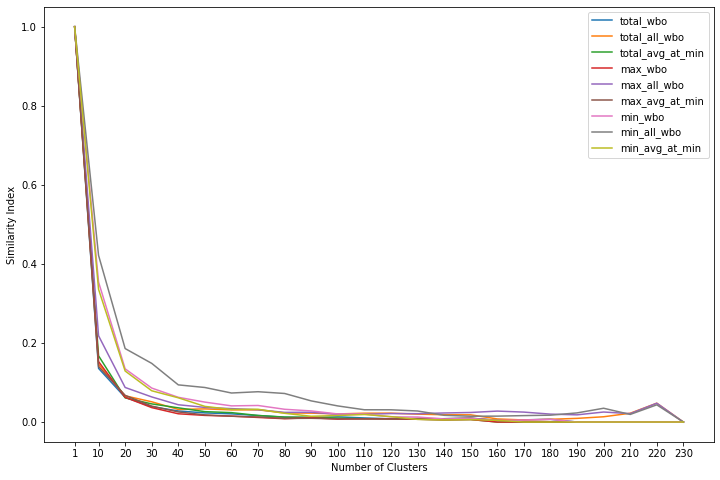

In [65]:
# Plotting similarity to scan energy vs number of clusters.
plt.figure(figsize=(12,8))
for c in clusterings:
    plt.plot(cluster_counts, c["similarity_to_scan_energy"], label=c["name"])
plt.xlabel("Number of Clusters")
plt.ylabel("Similarity Index")
plt.xticks(cluster_counts)
plt.yticks(np.arange(0, 11, 2) / 10)
plt.legend();

## Testing

In [53]:
import unittest


class TestClustering(unittest.TestCase):

    #
    # Cluster similarity evaluation
    #

    def test_jaccard_index(self):
        # When clustering by "dist1", a, b, and c all belong together.
        # When clustering by "dist2", only a and b belong together.
        data = [GridOptData("a"), GridOptData("b"), GridOptData("c")]
        data[0].cluster_id = {"dist1": 0, "dist2": 0}
        data[1].cluster_id = {"dist1": 0, "dist2": 0}
        data[2].cluster_id = {"dist1": 0, "dist2": 1}
        self.assertEqual(clustering_jaccard_index(data, "dist1", "dist2"),
                         1 / 3)

    def test_jaccard_index_same_cluster(self):
        # Index should be 1 when the clusterings are all the same, even
        # though the id's differ.
        data = [GridOptData("a"), GridOptData("b"), GridOptData("c")]
        data[0].cluster_id = {"dist1": 1, "dist2": 2}
        data[1].cluster_id = {"dist1": 1, "dist2": 2}
        data[2].cluster_id = {"dist1": 1, "dist2": 2}
        self.assertEqual(clustering_jaccard_index(data, "dist1", "dist2"), 1)

    #
    # Distance functions
    #

    def test_scan_energy_distance(self):
        a = GridOptData("a")
        b = GridOptData("b")
        a.scan_energies = np.zeros(SCAN_FRAMES)
        b.scan_energies = np.ones(SCAN_FRAMES)
        self.assertEqual(scan_energy_distance(a, b), np.sqrt(SCAN_FRAMES))

    def test_normalized_scan_energy_distance_assigns_no_distance(self):
        a = GridOptData("a")
        b = GridOptData("b")
        a.scan_energies = np.ones(SCAN_FRAMES)
        b.scan_energies = np.full(SCAN_FRAMES, 2)

        # Even though a has all 1's and b has all 2's, they should still have 0
        # distance because they both normalize to all 1's.
        self.assertEqual(normalized_scan_energy_distance(a, b), 0.0)

    def test_normalized_scan_energy_distance_handles_zeros(self):
        a = GridOptData("a")
        b = GridOptData("b")
        a.scan_energies = np.zeros(SCAN_FRAMES)
        b.scan_energies = np.ones(SCAN_FRAMES)
        self.assertEqual(normalized_scan_energy_distance(a, b),
                         np.sqrt(SCAN_FRAMES))


unittest.main(argv=[''], verbosity=2, exit=False)


test_jaccard_index (__main__.TestClustering) ... ok
test_jaccard_index_same_cluster (__main__.TestClustering) ... ok
test_normalized_scan_energy_distance_assigns_no_distance (__main__.TestClustering) ... ok
test_normalized_scan_energy_distance_handles_zeros (__main__.TestClustering) ... ok
test_scan_energy_distance (__main__.TestClustering) ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.004s

OK
